# Word to vec junto con steam

__author__ = "Andres Ardila, Johan Triviño, Jenny Gamboa"
__maintainer__ = "Proyecto de Profundización"
__copyright__ = "Copyright 2023"
__version__ = "0.0.1"

Con este modelo se busca la mezcla de lo mejor de los dos modelos.

- Liberias rqueridas para el modelo.

In [ ]:
from __future__ import absolute_import, division, print_function

import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import string

import nltk
!pip install gensim
#import gensim.models.word2vec as w2v
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec as w2v
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import gensim
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import SnowballStemmer
import pandas as pd
from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display,HTML
from google.colab import files
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Comunicación con drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- LLamado del archivo csv del normograma.

In [ ]:
url ="/content/drive/MyDrive/concatenado/procesado_normas.json"

In [ ]:
Norma=pd.read_json(url, encoding='utf-8-sig')
Norma.shape

(665, 4)

In [ ]:
Norma

,index,No_Articulo,Contenido_Articulo,Norma
0,0,Artículo 1.,Artículo 1. Publicidad de proyectos de pliegos...,Decreto_2170_de_2002
1,1,Artículo 11.,Artículo 11. Menor Cuantía. Para la celebració...,Decreto_2170_de_2002
2,2,Artículo 12.,Artículo 12. Del sistema de conformación dinám...,Decreto_2170_de_2002
3,3,Artículo 13.,Artículo 13. De los contratos de prestación de...,Decreto_2170_de_2002
4,4,Artículo 14.,"Artículo 14. Modificado por el art. 1, Decreto...",Decreto_2170_de_2002
...,...,...,...,...
660,84,ARTÍCULO 81º.,ARTÍCULO 81º. De la Derogatoria y de la Vigenc...,Ley_80_de_1993
661,85,ARTÍCULO 8º.,ARTÍCULO 8º. De las Inhabilidades e Incompatib...,Ley_80_de_1993
662,86,ARTÍCULO 9A.,"ARTÍCULO 9A. Adicionado por el art. 8, Ley 201...",Ley_80_de_1993
663,87,ARTÍCULO 9º.,ARTÍCULO 9º. De las Inhabilidades e Incompatib...,Ley_80_de_1993


- Limpieza de columnas que no influyen en el análisis

In [ ]:
Norma.drop(['index'], axis = 'columns', inplace=True)
Norma

,No_Articulo,Contenido_Articulo,Norma
0,Artículo 1.,Artículo 1. Publicidad de proyectos de pliegos...,Decreto_2170_de_2002
1,Artículo 11.,Artículo 11. Menor Cuantía. Para la celebració...,Decreto_2170_de_2002
2,Artículo 12.,Artículo 12. Del sistema de conformación dinám...,Decreto_2170_de_2002
3,Artículo 13.,Artículo 13. De los contratos de prestación de...,Decreto_2170_de_2002
4,Artículo 14.,"Artículo 14. Modificado por el art. 1, Decreto...",Decreto_2170_de_2002
...,...,...,...
660,ARTÍCULO 81º.,ARTÍCULO 81º. De la Derogatoria y de la Vigenc...,Ley_80_de_1993
661,ARTÍCULO 8º.,ARTÍCULO 8º. De las Inhabilidades e Incompatib...,Ley_80_de_1993
662,ARTÍCULO 9A.,"ARTÍCULO 9A. Adicionado por el art. 8, Ley 201...",Ley_80_de_1993
663,ARTÍCULO 9º.,ARTÍCULO 9º. De las Inhabilidades e Incompatib...,Ley_80_de_1993


- Definir el idioma de las stopwords en español

In [ ]:
stopwords = set(stopwords.words('spanish'))

- Ciclos para la limpieza de los articulos, limpiando los caracteres especiales y las stopwords, y almacenarlas en una lista.

In [ ]:
articulos = list(Norma['Contenido_Articulo'])
articulos_limpio = []
#Eliminamos líneas vacías 
for i in range(len(articulos)):
    art_limpio = []
    for linea in articulos[i].split("."):       
          linea = bytes(linea, 'utf-8').decode('utf-8', 'ignore')
          linea = "".join(c for c in linea if (c not in string.punctuation and c not in ['','¡','¿'])).lower()
          linea = linea.split(" ")
          #Eliminamos stopwords
          linea1=[]
          for palabra in list(linea):              
              if palabra not in stopwords and palabra not in string.punctuation:
                  linea1.append(palabra)
          art_limpio += linea1      
    articulos_limpio += [art_limpio]

- Función para la aplicación del steaming al corpus del texto. 

In [ ]:
def steamer(Corpus):
        
  Corpus=[i.lower() for i in Corpus]
  stem=SnowballStemmer('spanish')
  
  #Corpus=[' '.join([j for j in i.split() if  j not in stopwords])  for i in Corpus]
  
  Corpus=[' '.join([stem.stem(j) for j in i.split()]) for i in Corpus]
  return Corpus

- Ciclo para crear array de corpus luego de aplicar steam.

In [ ]:
articulos_limpio_stm =[]
for i in range (len(articulos_limpio)):
  art_pos=[' '.join([j for j in articulos_limpio[i]])]
  #print(art_pos)
  art_limpio_stm =[]
  Corpus= steamer(art_pos)
  linea = Corpus[0].split(" ")
  articulos_limpio_stm.append(linea)

- Vectorización del array.

In [ ]:
art2vec = w2v(
    articulos_limpio_stm,
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    vector_size=256,
    min_count=50,
    window=12
)

- Ciclo para crear array con las etiquetas.

In [ ]:
labels = []
for word in art2vec.wv.key_to_index:
    labels.append(word)

- Funciones para la separación del texto, busqueda del artículo.

In [ ]:
#funcion para separar texto
def septext(palabra):
  palabra = str(palabra)
  palabra = palabra.split(' ')
  palab=['art']
  count = 0
  Corpus= steamer(palabra)
  palabra = Corpus
  for pala in palabra:
    if pala in labels:
       count += 1
       if count >1:
        palab.append(pala)
       else:
         palab = [pala] 

  if len(palab) == 0:
    palabra= 'art'
  return palab

#Funcion para encontrar para encontrar Articulos
def art2find(palabra): 
  similaresword=[i[0] for i in art2vec.wv.most_similar(positive=palabra)]
  vword=art2vec.wv[palabra]
  cercanas =[]
  indices = []
  for i in similaresword:
    cercanas.append(i)   
  
  for j in cercanas:
    str_match = list(filter(lambda x: palabra and j in x, articulos_limpio_stm))    
    for k in str_match:
      ind = articulos_limpio_stm.index(k)
      if ind not in indices:
        indices.append(ind)
  return indices

- Función para la busqueda de los artículos relacionados, partiendo frases clave. 

In [ ]:
def funcion_recomendacionw2v(entrada, Number):
  z=int(Number)
  entrada= septext(entrada)
  print(entrada)
  y = art2find(entrada)
  #print(y)
  ind=np.argsort(y,axis=0)
  return Norma[['Norma','No_Articulo', 'Contenido_Articulo']].loc[ind[0:z]]

interact(funcion_recomendacionw2v,entrada="art", Number=['1', '2', '3', '4', '5'])

In [ ]:
interact(funcion_recomendacionw2v,entrada="art", Number=['1', '2', '3', '4', '5'])

interactive(children=(Text(value='art', description='entrada'), Dropdown(description='Number', options=('1', '…

<function __main__.funcion_recomendacionw2v(entrada, Number)>

In [ ]:
  entrada= septext('¿cuándo es un contrato de mínima cuantía?')
  print(entrada)
  y = art2find(entrada)
  #print(y)
  ind=np.argsort(y,axis=0)
  Nor = Norma[['Norma','No_Articulo', 'Contenido_Articulo']].loc[ind[0:20]]
  

['contrat', 'minim']


In [ ]:
Nor

,Norma,No_Articulo,Contenido_Articulo
59,Decreto_2474_de_2008,Artículo 27.,Artículo 27. Procedimiento de la subasta inver...
60,Decreto_2474_de_2008,Artículo 28.,Artículo 28. Fallas técnicas ocurridas durante...
187,Decreto_734_de_2012,Artículo 2.2.10.,Artículo 2.2.10. Oferta con valor artificialme...
188,Decreto_734_de_2012,Artículo 2.2.2.,Artículo 2.2.2. Acto administrativo de apertur...
189,Decreto_734_de_2012,Artículo 2.2.3.,Artículo 2.2.3. Contenido mínimo del pliego de...
460,Decreto_734_de_2012,Artículo 8.1.6.,Artículo 8.1.6. De la desconcentración de los ...
190,Decreto_734_de_2012,Artículo 2.2.4.,Artículo 2.2.4. Modificación del aviso de conv...
377,Decreto_734_de_2012,Artículo 5.4.2.,Artículo 5.4.2. Divisibilidad de las garantías...
61,Decreto_2474_de_2008,Artículo 29.,Artículo 29. Régimen aplicable. En lo no previ...
62,Decreto_2474_de_2008,Artículo 2.,Artículo 2. Modalidades de selección. De confo...


In [ ]:
type(Nor)

pandas.core.frame.DataFrame

In [ ]:
Nor.to_csv('w2v-Steam.csv', encoding='utf-8-sig')
files.download('w2v-Steam.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
text= "".join(Contenido_Articulo for Contenido_Articulo in Nor.Contenido_Articulo)

In [ ]:
wordcloud = WordCloud(width=800, height=400, max_font_size=100, background_color="white").generate(text)

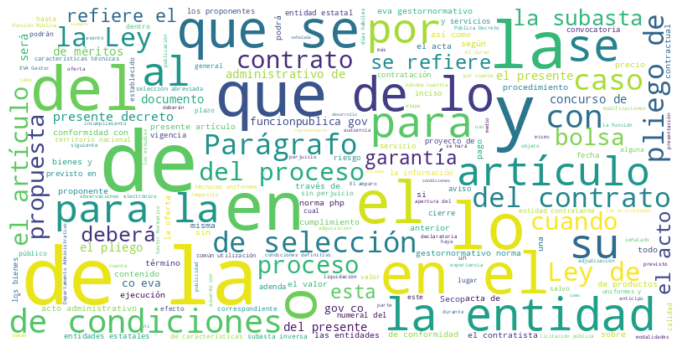

In [ ]:
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()